In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [3]:
#format_plots()
#format_pizza_plots()
c = PlotConfig()

In [4]:
## update data
def filter_df(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [5]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='cubehelix', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    c = PlotConfig()
    #fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_decoder_confusion_pre.pdf')

In [6]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [7]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
n=16
df = df.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data)
data_labels = data.index.get_level_values('age').to_numpy()

In [8]:
# choose a model for decoder
clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 200)
#clf = LinearRegression()
#clf = LogisticRegression()
#clf = KNeighborsRegressor(n_neighbors=5)

# choose cross validation scheme
cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
#cv=5

#number of iterations for shuffle
it=10

In [9]:
# process data

In [10]:
# make linear
y =data.index.get_level_values('age').to_numpy()
#X=data.to_numpy()
X=np.log(data+1e-6)

In [11]:
# perform PCA if wanted
#pca=PCA(n_components=10)
#pcs=pca.fit_transform(np.log(data+1e-6))
#pcs=pca.fit_transform(data+1e-6)
#X=pcs

In [12]:
# perform data regularization
'''
from sklearn.cross_decomposition import PLSRegression
# PLS regression
mdl = PLSRegression(n_components=5)
mdl.fit(X, y)
X=mdl.transform(X)
'''

'\nfrom sklearn.cross_decomposition import PLSRegression\n# PLS regression\nmdl = PLSRegression(n_components=5)\nmdl.fit(X, y)\nX=mdl.transform(X)\n'

In [13]:
#decoder
y_pred = cross_val_predict(clf, X, y, cv=cv)
#r2 = r2_score(y, y_pred)
#print(r2)
acc=np.mean(np.mean(cross_val_score(clf, X, y, cv=cv)))
print(acc)

0.59375


In [14]:
#shuffle
ysh_score=[]
ysh=[]
ysh_predict=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
    y_score_temp = cross_val_score(clf, X, ysh_temp, cv=cv)
    ysh.extend(ysh_temp)
    ysh_predict.extend(y_pred_temp)
    ysh_score.append(np.mean(y_score_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.97s/it]


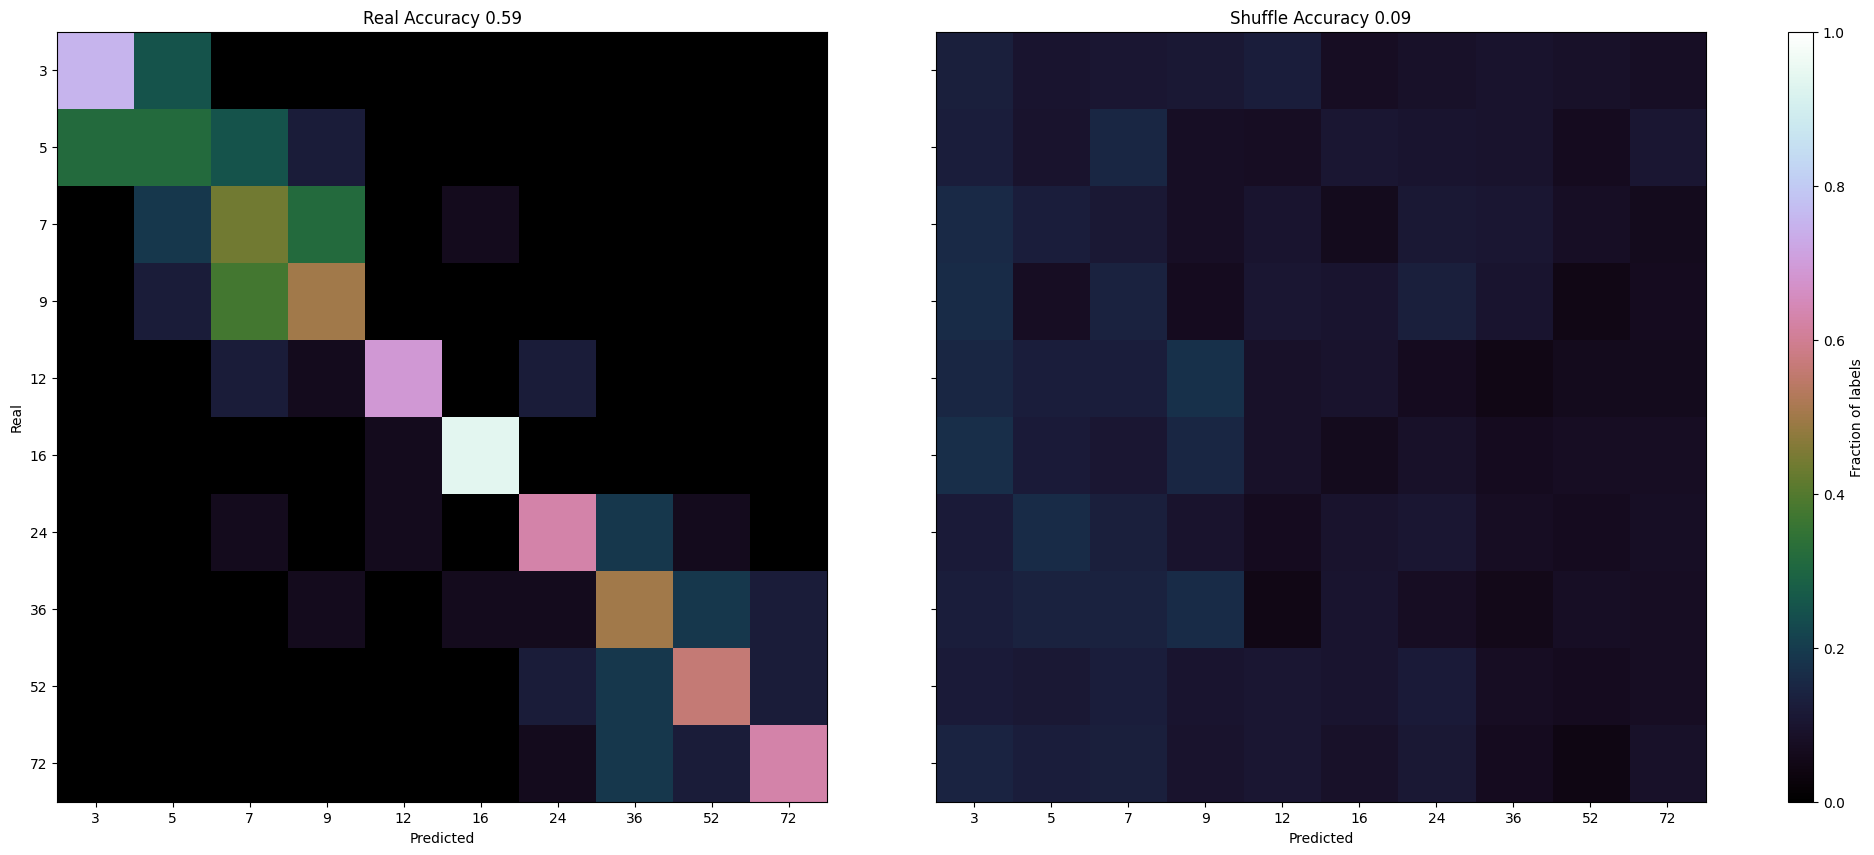

In [15]:
# plot confusion matrix
plot_cm(y,y_pred,ysh,ysh_predict)

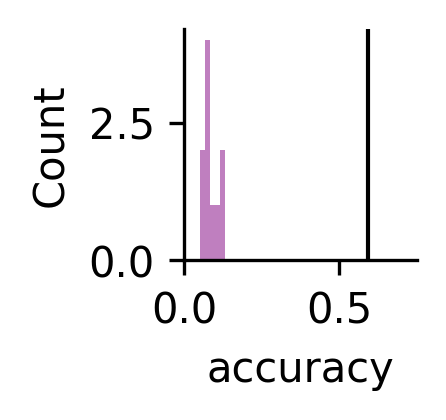

In [16]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_score, fill=True, element='step', lw=0, color='purple', alpha=0.5)
ax.axvline(acc, color='black', lw=1)
#plt.xticks(ticks=[])
ax.set(ylabel='Count')
ax.set(xlabel='accuracy')
plt.xlim([0,0.75])
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_decoder_accuracy_pre.pdf')

In [17]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
n=16
df = df.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)
df.groupby('age').size()

age
4      16
8      16
12     16
16     16
20     16
24     16
28     15
32     16
36     16
40     16
44     16
48     16
52     16
56     16
60     16
64     16
68     16
72     16
78     16
80     16
84     16
90     16
103     9
dtype: int64